In [3]:
%matplotlib inline
import cv2
import numpy as np
from matplotlib import pyplot as plt

import os
import sys
from paths import Paths
paths = Paths()
sys.path.append(paths.scripts_root)
import util

from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

paths.print_paths()


Paths defined in paths module:
 paths.projects_root: /Users/trafferty/data/projects
 paths.ws_dir: /Users/trafferty/workspace
 paths.tmp_root: /Users/trafferty/data/tmp
 paths.mii_home: /Users/trafferty/dev
 paths.results_root: /Users/trafferty/data/results
 paths.data_root: /Users/trafferty/data
 paths.inhouse: /Users/trafferty/dev/src/inhouse
 paths.notebook_root: /Users/trafferty/data/notebooks
 paths.images_root: /Users/trafferty/data/images
 paths.tmp_dir: /Users/trafferty/tmp
 paths.scripts_root: /Users/trafferty/data/scripts


In [4]:
#fnames = ['/home/trafferty/tmp_noback/TTM_Vibration/TTM_Data_2017_06_28/TTM_Data_IMCS_pcap/TTM_Data_2017_06_28_01.csv',
#           '/home/trafferty/tmp/TTM_Vibration/TTM_Data_2017_06_28/TTM_Data_IMCS_pcap/TTM_Data_2017_06_28_02.csv',
#           '/home/trafferty/tmp/TTM_Vibration/TTM_Data_2017_06_28/TTM_Data_IMCS_pcap/TTM_Data_2017_06_28_03.csv']
#fnames = ['/home/trafferty/tmp/TTM_Vibration/TTM_Data_2017_06_28/TTM_WS_2017_06_29_IP8.csv']
#fnames = ['/home/trafferty/tmp/TTM_Vibration/TTM_Data_2017_06_28/TTM_WS_2017_06_29_IP8_from_MISC.csv']
#fnames = ['/home/trafferty/tmp/TTM_Vibration/TTM_Data_2017_06_28/TTM_Data_IMCS_pcap/TTM_Data_2017_06_28_02_StatusDO-to-MISC.csv']
#fnames = ['/home/trafferty/tmp/TTM_Vibration/Wireshark_Data_2017_07_07/IMCS_traffic_2017_07_07_52-imprints.csv']


fnames = ['/Users/trafferty/tmp/TTM_20180621_imprint28-30.csv']

ttm_ws_data = []
for fname in fnames:
    with open(fname, 'r') as csv_file:
        ttm_ws = csv_file.readlines()
        ttm_ws_data.append(ttm_ws)
        print("Read in %d lines from %s" %(len(ttm_ws), os.path.basename(fname)))
        
from os.path import expanduser

tmp_dir = paths.tmp_dir
ws_dir = paths.ws_dir

IMCS_mode = False
TTM_Merge = False

if IMCS_mode:
    TTM_Merge = False

Read in 29458 lines from TTM_20180621_imprint28-30.csv


In [27]:
ttm_ws[1]

'"19","14.914718","192.168.2.11","192.168.2.1","UDP","126","5259  >  5259 Len=84"\n'

In [54]:
def parse_into_data_sets(data, pcap=False):
    data_ranges = []
    data_sets = []
    data_gaps = []
    max_delta = 2
    start = 0
    cnt = 0
    found_first = False

    for idx, d in enumerate(data):
        if pcap:
            l = d.summary_line.replace(' ', ',')
            d = l.split(',')
        
        if len(d) <= 1:
            print("Found blank line: ", d)
            continue

        if found_first == False:
            found_first = True
            ts_prev = float(d.split(",")[1][1:-1])
#             cum = 0.0
#             data_ts = []
        else:
            ts = float(d.split(",")[1][1:-1])
            delta = ts - ts_prev
            if delta > max_delta:
                data_gaps.append(delta)
                
                end = idx - 1

                data_sets.append( [ data[start:end] ] )
                data_ranges.append([start, end])
                cnt += 1                
                ts1 = float(data[start].split(",")[1][1:-1])
                ts2 = float(data[end].split(",")[1][1:-1])
                id1 = float(data[start].split(",")[0][1:-1])
                id2 = float(data[end].split(",")[0][1:-1])
                print("Data set %d, range: %d - %d (WS IDs: %d - %d) (total: %d) elapsed time: %f" % (cnt, start,end, id1, id2, (end-start), (ts2-ts1)))

#                 cum = 0.0
#                 data_ts = []
                start = idx
#             else:
#                 cum += delta
#                 data_ts.append(cum)
            ts_prev = ts

    end = idx
    data_sets.append( [ data[start:end] ] )
    data_ranges.append([start, end])
    cnt += 1
    ts1 = float(data[start].split(",")[1][1:-1])
    ts2 = float(data[end].split(",")[1][1:-1])
    id1 = float(data[start].split(",")[0][1:-1])
    id2 = float(data[end].split(",")[0][1:-1])
    print("Data set %d, range: %d - %d (WS IDs: %d - %d) (total: %d) elapsed time: %f" % (cnt, start,end, id1, id2, (end-start), (ts2-ts1)))
        
    print(data_gaps)
    return data_ranges, data_sets, data_gaps



In [69]:
def parse_into_single_data_set(data):
    data_ranges = []
    data_sets = []
    start = 1
    end = len(data) - 1
    data_sets.append( [ data[start:end] ] )
    #data_ranges.append(data[start:idx])
    len(data_ranges)
        
    return data_ranges, data_sets, []


In [70]:
'''
    data_set[0] = list, n=len(data_set), raw data from csv: "105","1366.450402000","192.168.2.11","192.168.2.1","TCP","118","49203 > 5259 [PSH, ACK] Seq=321 Ack=1 Win=256 Len=64"
    data_set[1] = list, n=num of packets with data, deltas between data packets
    data_set[1] = list, n=num of packets with data, time stamps
    data_set[2] = list, n=num of packets with data, data lengths in packets
'''
 
for ttm_ws in ttm_ws_data:
    if IMCS_mode:
        print("IMCS mode indicated; parsing into single dataset")
        data_ranges, data_sets, data_gaps = parse_into_single_data_set(ttm_ws[1:])
    else:
        print("Parsing into datasets...")
        data_ranges, data_sets, data_gaps = parse_into_data_sets(ttm_ws[1:])
    
    print("Data set cnt:", len(data_sets))
    print("------------------------------------------------")
    
    for ds_num, data_set in enumerate(data_sets):
        delay_set = []
        packet_len_lst = []
        for idx, line in enumerate(data_set[0]):
            if idx == 0:
                ts_prev = float(line.split(",")[1][1:-1])
                cum = 0.0
                data_ts = []
                large_delay_ids = []
            else:
                idx = line.find("Len=")
                if idx >= 0:
                    packet_len = int(line[idx:-2].split("=")[1])
                    packet_len_lst.append(packet_len)
                    
                    ts = float(line.split(",")[1][1:-1])
                    delta = ts - ts_prev
                    delay_set.append(delta)
                    ts_prev = ts

                    cum += delta
                    data_ts.append(cum)
                    
                    thresh = 0.015
                    if delta > thresh:
                        _id = line.split(",")[0][1:-1]
                        _ts = line.split(",")[1][1:-1]
                        large_delay_ids.append( (_id, cum, delta))
                        print("[%d][%s, %s] Delta = %f (> thresh:%f)" % (ds_num, _id, _ts, delta, thresh))
                    
                #else:
                    #print("Found non-data msg: ", line[:-1])

        data_set.append(data_ts)
        data_set.append(delay_set)
        data_set.append(packet_len_lst)
        data_set.append(large_delay_ids)
        if ds_num == 0:
            data_set.append(0)
            print("data set 0, no gap")
        else:
            data_set.append(data_gaps[ds_num-1])
            print("data set %d, gap: %f" % (ds_num, data_gaps[ds_num-1]))
        

Parsing into datasets...
Data set 1, range: 0 - 9816 (WS IDs: 19 - 19666) (total: 9816) elapsed time: 30.408301
Data set 2, range: 9817 - 19637 (WS IDs: 19675 - 39329) (total: 9820) elapsed time: 30.414452
Data set 3, range: 19638 - 29456 (WS IDs: 39341 - 58992) (total: 9818) elapsed time: 30.408692
[24.857067, 24.605846999999997]
Data set cnt: 3
------------------------------------------------
data set 0, no gap
data set 1, gap: 24.857067
data set 2, gap: 24.605847


In [37]:
for idx, data_set in enumerate(data_sets):
    print("--------------------------------------------------")
    print("data_set[%d]:" % idx)
    raw =data_set[0]
    ts = data_set[1]
    deltas = data_set[2]
    packet_len = data_set[3]
    large_delay_ids = data_set[4]
    gap  = data_set[5]

    print("  Number of raw lines in data_set :", len(raw))
    print("  Number of delta pts             :", len(deltas))
    print("  Number of time stamps           :", len(ts))
    print("  Number of lines with packet data:", len(packet_len))
    print("  Data set gap                    :", gap)
    print("  first 5 TSs: %s" % (', '.join(str(e) for e in ts[0:5])) )
    print("  last  5 TSs: %s" % (', '.join(str(e) for e in ts[-5:])) )
    if len(large_delay_ids) > 0:
        print("  Delays occured at: ")
        for large_delay_id in large_delay_ids:
            print("   Wireshark id: %s, ts: %.3f, delay: %f" % (large_delay_id[0], float(large_delay_id[1]), large_delay_id[2]))

--------------------------------------------------
data_set[0]:
  Number of raw lines in data_set : 9816
  Number of delta pts             : 9815
  Number of time stamps           : 9815
  Number of lines with packet data: 9815
  Data set gap                    : 0
  first 5 TSs: 0.0001679999999986137, 0.003434999999999633, 0.006128999999999607, 0.009551000000000087, 0.012443999999998567
  last  5 TSs: 30.393276999999998, 30.396316999999996, 30.399147999999997, 30.40224, 30.405313999999997
--------------------------------------------------
data_set[1]:
  Number of raw lines in data_set : 9820
  Number of delta pts             : 9819
  Number of time stamps           : 9819
  Number of lines with packet data: 9819
  Data set gap                    : 24.857067
  first 5 TSs: 0.0010169999999902757, 0.002927999999997155, 0.004125000000001933, 0.006039000000001238, 0.007818000000000325
  last  5 TSs: 30.399231, 30.402293, 30.40544, 30.408502999999996, 30.411626999999996
--------------------

In [38]:
if TTM_Merge:
    print("Merging datasets...")
    merged_data_set = []
    merged_data_set.append( [ [], [], [], [] ])
    for data_set in data_sets:        
        for idx, d in enumerate(data_set[1]):
            merged_data_set[0][0].append(data_set[0][idx])
            merged_data_set[0][1].append(data_set[1][idx])
            merged_data_set[0][2].append(data_set[2][idx])
            merged_data_set[0][3].append(data_set[3][idx])
            
len(merged_data_set[0][0])

29451

Creating PDF (/Users/trafferty/tmp/TTM_20180621_imprint28-30.pdf) with 1 pages.
Total plots: 3, plots per page: 3
 plot 0, data pts: 9815, 9815
 plot 1, data pts: 9819, 9819
 plot 2, data pts: 9817, 9817
Saving pdf...


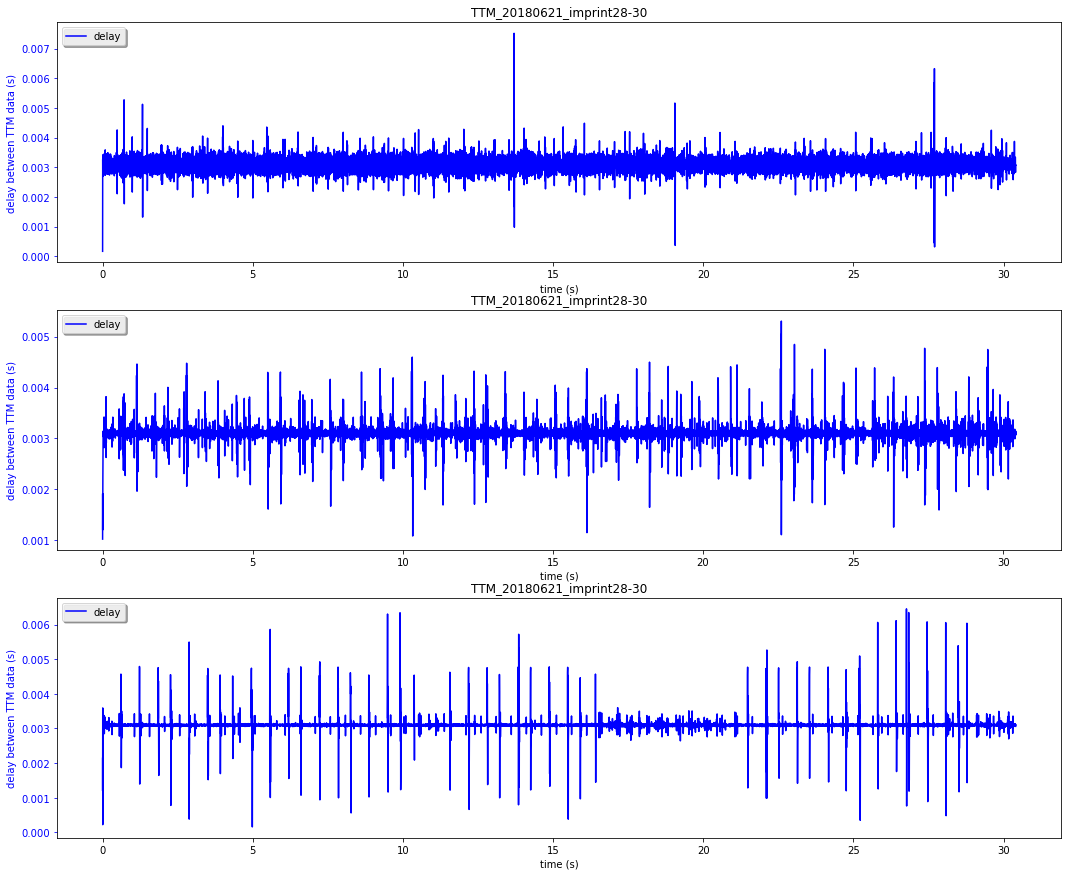

In [39]:
save_pdf = True

if TTM_Merge:
    print("Merging datasets...")
    merged_data_set = []
    merged_data_set.append( [ [], [], [], [] ])
    cum = 0.0
    for data_set in data_sets:        
        for idx, d in enumerate(data_set[1]):
            cum += data_set[2][idx]
            merged_data_set[0][0].append(data_set[0][idx])
            merged_data_set[0][1].append(cum)
            merged_data_set[0][2].append(data_set[2][idx])
            merged_data_set[0][3].append(data_set[3][idx])
        cum += data_set[5]
            
    data_sets_to_plot = merged_data_set
else:
    data_sets_to_plot = data_sets

num_plots = len(data_sets_to_plot)

if save_pdf:
    plot_file_pdf = "%s/%s.pdf" % (tmp_dir, os.path.basename(fnames[0][0:-4]))
    from matplotlib.backends.backend_pdf import PdfPages
    import datetime
    pdf = PdfPages(plot_file_pdf)
    # set the file's metadata via the PdfPages object:
    d = pdf.infodict() 
    d['Title'] = os.path.basename(fnames[0][0:-4])
    d['Author'] = 'Tom Rafferty'
    d['Subject'] = 'TTM IP8 Interface Analysis'
    d['CreationDate'] = datetime.datetime.today()
    d['ModDate'] = datetime.datetime.today()

    # setup vars to control page layout
    plots_per_page = num_plots
    num_pages = np.ceil(num_plots / plots_per_page)
    nb_pages = int(np.ceil(num_plots / float(plots_per_page)))
    grid_size = (plots_per_page, 1)

    print("Creating PDF (%s) with %d pages." % (plot_file_pdf, num_pages))
    print("Total plots: %d, plots per page: %d" % (num_plots, plots_per_page))

    fig, axes = plt.subplots(nrows=num_plots, ncols=1, squeeze=True, figsize=(18,(5*num_plots)))

for idx, data_set in enumerate(data_sets_to_plot):
    if len(data_set[0]) ==0:
        continue
        
    print( " plot %d, data pts: %d, %d" % (idx, len(data_set[1]),len(data_set[2])))
    if num_plots > 1:
        ax1 = axes[idx]
    else:
        ax1 = axes

    ax1.plot(data_set[1], data_set[2], color='b', label='delay')
    ax1.set_xlabel('time (s)')
    # Make the y-axis label, ticks and tick labels match the line color.
    ax1.set_ylabel('delay between TTM data (s)', color='b')
    ax1.tick_params('y', colors='b')
    ax1.set_title(os.path.basename(fnames[0][0:-4]))
    leg1 = ax1.legend(loc='upper left', shadow=True)

#     ax2 = ax1.twinx()
#     ax2.plot(data_set[1], data_set[3],  color='c', label='packet size')
#     ax2.set_ylabel('packet size', color='m')
#     ax2.tick_params('y', colors='m')
#     leg2 = ax2.legend(loc='upper right', shadow=True)
    
fig.savefig("%s/%s.png" % (tmp_dir, os.path.basename(fnames[0][0:-4])))

if save_pdf:
#         for fig in figs:
#             fig.savefig(pdf, format='pdf')
    print("Saving pdf...")
    fig.savefig(pdf, format='pdf')
    pdf.close()


## Now, another parser using pyshark

In [5]:
import pyshark

In [6]:
fnames = ['/Users/trafferty/tmp/TTM_20180621_imprint27.pcapng']

ttm_cap_data = []
for fname in fnames:
    ttm_cap = pyshark.FileCapture(fname, display_filter="udp and ip.dst==192.168.2.1", only_summaries=True)
    ttm_cap_data.append(ttm_cap)
    print("Read in %d lines from %s" %(len(ttm_cap), os.path.basename(fname)))

Read in 0 lines from TTM_20180621_imprint27.pcapng


In [7]:
ttm_cap = ttm_cap_data[0]
ttm_cap
#print(pkt)

<FileCapture /Users/trafferty/tmp/TTM_20180621_imprint27.pcapng>

In [11]:
ttm_cap = ttm_cap_data[0]
for pkt in ttm_cap[0:20]:
    print(pkt.time)

TypeError: unorderable types: slice() >= int()

In [61]:
l =pkt.summary_line.replace(' ', ',')
l.split(',')
# csv_file
# l.replace(' ', ',').split



['19654',
 '206.724583',
 '192.168.2.11',
 '192.168.2.1',
 'UDP',
 '126',
 '5259',
 '\\xe2\\x86\\x92',
 '5259',
 'Len=84']

In [55]:
parse_into_data_sets(ttm_cap, pcap=True)

AttributeError: 'list' object has no attribute 'split'

In [23]:
deltas = []
for idx, pkt in enumerate(ttm_cap):
    if idx == 0:
        ts_prev = float(pkt.time)
    else:
        ts = float(pkt.time)
        delta = ts - ts_prev
        ts_prev = ts
        deltas.append(delta)
deltas_np = np.array(deltas)

In [25]:
deltas_np.max()

0.0063930000000027576

In [47]:
tt